# Abstractive Text Summarization - LSTM Vanilla

In [1]:
import re
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences

import tensorflow as tf
from tensorflow.keras.layers import Input, LSTM, Embedding, Dense, Concatenate, TimeDistributed, Bidirectional, GRU
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import EarlyStopping
from keras import backend as K 
from tensorflow.python.keras.layers import Layer

[nltk_data] Downloading package stopwords to /usr/share/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


Using TensorFlow backend.


In [2]:
!pip install openpyxl

### Importing Data

In [3]:
data = pd.read_excel('../input/inshorts-news-data/Inshorts Cleaned Data.xlsx')

In [4]:
data.drop(['Source ', 'Time ', 'Publish Date'], axis=1, inplace=True)
data.head()

,Headline,Short
0,4 ex-bank officials booked for cheating bank o...,The CBI on Saturday booked four former officia...
1,Supreme Court to go paperless in 6 months: CJI,Chief Justice JS Khehar has said the Supreme C...
2,"At least 3 killed, 30 injured in blast in Sylh...","At least three people were killed, including a..."
3,Why has Reliance been barred from trading in f...,Mukesh Ambani-led Reliance Industries (RIL) wa...
4,Was stopped from entering my own studio at Tim...,TV news anchor Arnab Goswami has said he was t...


### Punctuation and Stopword Removal

In [5]:
stop_words = stopwords.words('english')

def preprocess(text):
    text = text.lower()
    
    tokens = [w for w in text.split() if not w in stop_words]
    text = " ".join(tokens)
    text = text.replace("'s",'')
    text = text.replace(".",'')
    text = re.sub(r'\(.*\)','',text)
    text = re.sub(r'[^a-zA-Z0-9. ]',' ',text)
    text = re.sub(r'\.','. ',text)
    text = re.sub(r'\s+', ' ', text)
    return text

### Lemmatization

In [6]:
import spacy

nlp = spacy.load('en_core_web_sm', disable=['parser', 'ner'])
allowed_postags = ['NOUN', 'ADJ', 'VERB', 'ADV']
def lemmatize_text(text):
    doc = nlp(text)
    return ' '.join([token.lemma_ for token in doc])

In [7]:
data.rename(columns={'Headline': 'headlines', 'Short': 'text'}, inplace=True)

In [8]:
original_text = str(data['text'][0])
original_headline = str(data['headlines'][0])

In [9]:
processed_text = data['text'].apply(preprocess)
data['text'] = processed_text.apply(lemmatize_text)
data['headlines'] = data['headlines'].apply(lambda x : '_START_ '+ x + ' _END_')

for i in range(2):
    print('Summary:', data['headlines'][i],'Text:', data['text'][i], sep='\n')
    print()

Summary:
_START_ 4 ex-bank officials booked for cheating bank of ₹209 crore _END_
Text:
cbi saturday book four former official syndicate bank six other cheat forgery criminal conspiracy cause 209 crore loss state run bank accuse avail home loan credit syndicate bank basis forge fabricated document fund fraudulently transfer company own accuse person

Summary:
_START_ Supreme Court to go paperless in 6 months: CJI _END_
Text:
chief justice js khehar say supreme court go paperless six seven month bid save fund make judiciary eco friendly say apex court collect record electronically low court high court need file hard copy



### Sample Input

In [10]:
print("\nORIGINAL")
print(original_text)
print(original_headline)

print("\nREGEX CLEANING AND STOPWORD REMOVAL:")
print(processed_text[0])
# print(brief_cleaned_summary[0])

print("\nLEMMATIZATION + START AND END TOKEN")
print(data['text'][0])
print(data['headlines'][0])


ORIGINAL
The CBI on Saturday booked four former officials of Syndicate Bank and six others for cheating, forgery, criminal conspiracy and causing ₹209 crore loss to the state-run bank. The accused had availed home loans and credit from Syndicate Bank on the basis of forged and fabricated documents. These funds were fraudulently transferred to the companies owned by the accused persons.
4 ex-bank officials booked for cheating bank of ₹209 crore

REGEX CLEANING AND STOPWORD REMOVAL:
cbi saturday booked four former officials syndicate bank six others cheating forgery criminal conspiracy causing 209 crore loss state run bank accused availed home loans credit syndicate bank basis forged fabricated documents funds fraudulently transferred companies owned accused persons

LEMMATIZATION + START AND END TOKEN
cbi saturday book four former official syndicate bank six other cheat forgery criminal conspiracy cause 209 crore loss state run bank accuse avail home loan credit syndicate bank basis fo

In [11]:
headlines_length = [len(x.split()) for x in data.headlines]
text_length = [len(x.split()) for x in data.text]

In [12]:
max_length_x = max(text_length)
max_length_y = max(headlines_length)

In [13]:
print(max_length_x)
print(max_length_y)

71
16


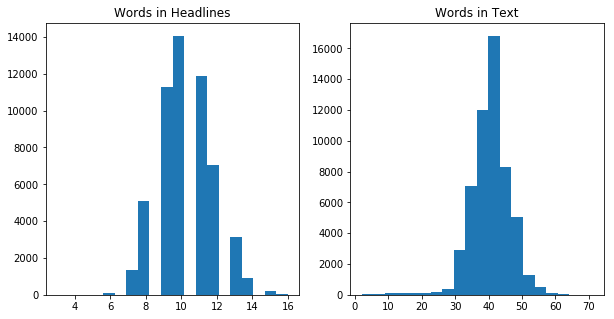

In [14]:
fig, (ax1, ax2) = plt.subplots(1,2, figsize = (10,5))
ax1.hist(headlines_length, bins = 20)
ax2.hist(text_length, bins = 20)

ax1.title.set_text("Words in Headlines")
ax2.title.set_text("Words in Text")
plt.show()

In [15]:
# #Model to summarize the text between 0-15 words for Summary and 0-100 words for Text
# max_text_len=80
# max_summary_len=20

In [16]:
#Select the Summaries and Text between max len defined above

cleaned_text =np.array(data['text'])
cleaned_summary=np.array(data['headlines'])

short_text=[]
short_summary=[]

for i in range(len(cleaned_text)):
    if(len(cleaned_summary[i].split())<=max_length_y and len(cleaned_text[i].split())<=max_length_x):
        short_text.append(cleaned_text[i])
        short_summary.append(cleaned_summary[i])
        
post_pre=pd.DataFrame({'text':short_text,'summary':short_summary})

In [17]:
post_pre.head(2)

,text,summary
0,cbi saturday book four former official syndica...,_START_ 4 ex-bank officials booked for cheatin...
1,chief justice js khehar say supreme court go p...,_START_ Supreme Court to go paperless in 6 mon...


### Splitting Data

In [18]:
from sklearn.model_selection import train_test_split
x_tr,x_val,y_tr,y_val=train_test_split(np.array(post_pre['text']),np.array(post_pre['summary']),test_size=0.1,random_state=0,shuffle=True)
x_tr,x_test,y_tr,y_test=train_test_split(x_tr, y_tr, test_size=0.1,random_state=0,shuffle=True)

### Tokenization

In [19]:
from keras.preprocessing.text import Tokenizer 
from keras.preprocessing.sequence import pad_sequences

x_tokenizer = Tokenizer() 
x_tokenizer.fit_on_texts(list(x_tr))

**RARE WORD ANALYSIS FOR X i.e 'text'**
* tot_cnt gives the size of vocabulary (which means every unique words in the text)

* cnt gives me the no. of rare words whose count falls below threshold

* tot_cnt - cnt gives me the top most common words

In [20]:
thresh=4

cnt=0
tot_cnt=0
freq=0
tot_freq=0

for key,value in x_tokenizer.word_counts.items():
    tot_cnt=tot_cnt+1
    tot_freq=tot_freq+value
    if(value<thresh):
        cnt=cnt+1
        freq=freq+value
    
print("% of rare words in vocabulary:",(cnt/tot_cnt)*100)
print("Total Coverage of rare words:",(freq/tot_freq)*100)

% of rare words in vocabulary: 63.80863005540416
Total Coverage of rare words: 2.8141709087975917


In [21]:

# prepare a tokenizer for reviews on training data
x_tokenizer = Tokenizer(num_words=tot_cnt-cnt) 
x_tokenizer.fit_on_texts(list(x_tr))

# convert text sequences into integer sequences (i.e one-hot encodeing all the words)
x_tr_seq    =   x_tokenizer.texts_to_sequences(x_tr) 
x_val_seq   =   x_tokenizer.texts_to_sequences(x_val)
x_test_seq   =   x_tokenizer.texts_to_sequences(x_test)


# padding zero upto maximum length
x_tr    =   pad_sequences(x_tr_seq,  maxlen=max_length_x, padding='post')
x_val   =   pad_sequences(x_val_seq, maxlen=max_length_x, padding='post')
x_test   =   pad_sequences(x_test_seq, maxlen=max_length_x, padding='post')


# size of vocabulary ( +1 for padding token)
x_voc   =  x_tokenizer.num_words + 1

print("Size of vocabulary in X = {}".format(x_voc))

Size of vocabulary in X = 20055


**RARE WORD ANALYSIS FOR Y i.e 'summary'**
* tot_cnt gives the size of vocabulary (which means every unique words in the text)

* cnt gives me the no. of rare words whose count falls below threshold

* tot_cnt - cnt gives me the top most common words

In [22]:
# prepare a tokenizer for reviews on training data
y_tokenizer = Tokenizer()   
y_tokenizer.fit_on_texts(list(y_tr))

In [23]:
thresh=6

cnt=0
tot_cnt=0
freq=0
tot_freq=0

for key,value in y_tokenizer.word_counts.items():
    tot_cnt=tot_cnt+1
    tot_freq=tot_freq+value
    if(value<thresh):
        cnt=cnt+1
        freq=freq+value
    
print("% of rare words in vocabulary:",(cnt/tot_cnt)*100)
print("Total Coverage of rare words:",(freq/tot_freq)*100)

% of rare words in vocabulary: 72.0510095642933
Total Coverage of rare words: 7.214802792017371


In [24]:
# prepare a tokenizer for reviews on training data
y_tokenizer = Tokenizer(num_words=tot_cnt-cnt) 
y_tokenizer.fit_on_texts(list(y_tr))

# convert text sequences into integer sequences (i.e one hot encode the text in Y)
y_tr_seq    =   y_tokenizer.texts_to_sequences(y_tr) 
y_val_seq   =   y_tokenizer.texts_to_sequences(y_val)
y_test_seq   =   y_tokenizer.texts_to_sequences(y_test) 


# padding zero upto maximum length
y_tr    =   pad_sequences(y_tr_seq, maxlen=max_length_y, padding='post')
y_val   =   pad_sequences(y_val_seq, maxlen=max_length_y, padding='post')
y_test   =   pad_sequences(y_test_seq, maxlen=max_length_y, padding='post')


# size of vocabulary
y_voc  =   y_tokenizer.num_words +1
print("Size of vocabulary in Y = {}".format(y_voc))

Size of vocabulary in Y = 7628


We will now remove "Summary" i.e Y (both train and val) which has only _START_ and _END_

In [25]:
ind=[]
for i in range(len(y_tr)):
    cnt=0
    for j in y_tr[i]:
        if j!=0:
            cnt=cnt+1
    if(cnt==2):
        ind.append(i)

y_tr=np.delete(y_tr,ind, axis=0)
x_tr=np.delete(x_tr,ind, axis=0)

In [26]:
ind=[]
for i in range(len(y_val)):
    cnt=0
    for j in y_val[i]:
        if j!=0:
            cnt=cnt+1
    if(cnt==2):
        ind.append(i)

y_val=np.delete(y_val,ind, axis=0)
x_val=np.delete(x_val,ind, axis=0)

### Building Model

In [27]:
latent_dim = 500
embedding_dim = 150

K.clear_session() 

encoder_inputs = Input(shape=(max_length_x,))
enc_emb =  Embedding(x_voc, embedding_dim,trainable=True)(encoder_inputs)

# Encoder 
encoder_lstm1 = LSTM(latent_dim,return_sequences=True,return_state=True) 
encoder_output1, state_h1, state_c1 = encoder_lstm1(enc_emb) 
encoder_lstm2 = LSTM(latent_dim,return_sequences=True,return_state=True) 
encoder_output2, state_h2, state_c2 = encoder_lstm2(encoder_output1) 
encoder_lstm3 = LSTM(latent_dim, return_state=True, return_sequences=True) 
encoder_outputs, state_h, state_c= encoder_lstm3(encoder_output2) 

# Decoder. 
decoder_inputs = Input(shape=(None,))
dec_emb_layer = Embedding(y_voc, embedding_dim,trainable=True)
dec_emb = dec_emb_layer(decoder_inputs) 

# LSTM using encoder_states as initial state
decoder_lstm = LSTM(latent_dim, return_sequences=True, return_state=True) 
decoder_outputs,decoder_fwd_state, decoder_back_state = decoder_lstm(dec_emb,initial_state=[state_h, state_c]) 

decoder_dense = TimeDistributed(Dense(y_voc, activation='softmax')) 
decoder_outputs = decoder_dense(decoder_outputs) 

model = Model([encoder_inputs, decoder_inputs], decoder_outputs) 
print(model.summary())

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 71)]         0                                            
__________________________________________________________________________________________________
embedding (Embedding)           (None, 71, 150)      3008250     input_1[0][0]                    
__________________________________________________________________________________________________
lstm (LSTM)                     [(None, 71, 500), (N 1302000     embedding[0][0]                  
__________________________________________________________________________________________________
input_2 (InputLayer)            [(None, None)]       0                                            
______________________________________________________________________________________________

In [29]:
model.compile(optimizer='rmsprop', loss='sparse_categorical_crossentropy')


In [30]:
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1,patience=2)


**Start fitting the model with the data**

In [31]:
history=model.fit(
    [x_tr,y_tr[:,:-1]], 
    y_tr.reshape(y_tr.shape[0],y_tr.shape[1], 1)[:,1:] ,
    epochs=45,
    callbacks=[es],
    batch_size=512, 
    validation_data=([x_val,y_val[:,:-1]], y_val.reshape(y_val.shape[0],y_val.shape[1], 1)[:,1:])
)


Train on 44633 samples, validate on 5511 samples
Epoch 1/45
44633/44633 [==============================] - 54s 1ms/sample - loss: 4.6089 - val_loss: 4.1521
Epoch 2/45
44633/44633 [==============================] - 44s 984us/sample - loss: 4.0712 - val_loss: 3.9227
Epoch 3/45
44633/44633 [==============================] - 44s 993us/sample - loss: 3.8897 - val_loss: 3.7929
Epoch 4/45
44633/44633 [==============================] - 44s 985us/sample - loss: 3.7420 - val_loss: 3.6657
Epoch 5/45
44633/44633 [==============================] - 44s 982us/sample - loss: 3.6123 - val_loss: 3.5678
Epoch 6/45
44633/44633 [==============================] - 44s 991us/sample - loss: 3.4847 - val_loss: 3.4794
Epoch 7/45
44633/44633 [==============================] - 44s 981us/sample - loss: 3.3657 - val_loss: 3.4007
Epoch 8/45
44633/44633 [==============================] - 44s 984us/sample - loss: 3.2567 - val_loss: 3.3277
Epoch 9/45
44633/44633 [==============================] - 44s 989us/sample - loss

In [32]:
model.save("nlp_45_weights.h5py")

**Visualize the model learning**

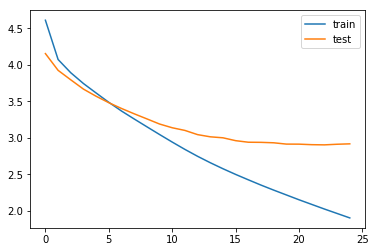

In [33]:
from matplotlib import pyplot
pyplot.plot(history.history['loss'], label='train')
pyplot.plot(history.history['val_loss'], label='test')
pyplot.legend()
pyplot.show()

**Next, let’s build the dictionary to convert the index to word for target and source vocabulary:**

### Inference

In [34]:
reverse_target_word_index=y_tokenizer.index_word
reverse_source_word_index=x_tokenizer.index_word
target_word_index=y_tokenizer.word_index

In [35]:
# Encode the input sequence to get the feature vector
encoder_model = Model(inputs=encoder_inputs,outputs=[encoder_outputs, state_h, state_c])

# Decoder setup
# Below tensors will hold the states of the previous time step
decoder_state_input_h = Input(shape=(latent_dim,))
decoder_state_input_c = Input(shape=(latent_dim,))
decoder_hidden_state_input = Input(shape=(max_length_x,latent_dim))

# Get the embeddings of the decoder sequence
dec_emb2= dec_emb_layer(decoder_inputs) 
# To predict the next word in the sequence, set the initial states to the states from the previous time step
decoder_outputs2, state_h2, state_c2 = decoder_lstm(dec_emb2, initial_state=[decoder_state_input_h, decoder_state_input_c])

# A dense softmax layer to generate prob dist. over the target vocabulary
decoder_outputs2 = decoder_dense(decoder_outputs2) 

# Final decoder model
decoder_model = Model(
    [decoder_inputs] + [decoder_hidden_state_input,decoder_state_input_h, decoder_state_input_c],
    [decoder_outputs2] + [state_h2, state_c2])

In [36]:
def decode_sequence(input_seq):
    # Encode the input as state vectors.
    e_out, e_h, e_c = encoder_model.predict(input_seq)
    
    # Generate empty target sequence of length 1.
    target_seq = np.zeros((1,1))
    
    # Populate the first word of target sequence with the start word.
    target_seq[0, 0] = target_word_index['start']

    stop_condition = False
    decoded_sentence = ''
    while not stop_condition:
      
        output_tokens, h, c = decoder_model.predict([target_seq] + [e_out, e_h, e_c])

        # Sample a token
        sampled_token_index = np.argmax(output_tokens[0, -1, :])
        sampled_token = reverse_target_word_index[sampled_token_index]
        
        if(sampled_token!='end'):
            decoded_sentence += ' '+sampled_token

        # Exit condition: either hit max length or find stop word.
        if (sampled_token == 'end'  or len(decoded_sentence.split()) >= (max_length_y-1)):
            stop_condition = True

        # Update the target sequence (of length 1).
        target_seq = np.zeros((1,1))
        target_seq[0, 0] = sampled_token_index

        # Update internal states
        e_h, e_c = h, c

    return decoded_sentence

In [39]:
def seq2summary(input_seq):
    newString=''
    for i in input_seq:
        if((i!=0 and i!=target_word_index['start']) and i!=target_word_index['end']):
            newString=newString+reverse_target_word_index[i]+' '
    return newString

def seq2text(input_seq):
    newString=''
    for i in input_seq:
        if(i!=0):
            newString=newString+reverse_source_word_index[i]+' '
    return newString

In [40]:
print("Review:",seq2text(padded_xtest[5]))
print("Original summary:",seq2summary(padded_ytest[5]))
print("Predicted summary:",decode_sequence(padded_xtest[5]))


Review: aditi agarwal self train artist jaipur rajasthan create art broken feather bird technique include outline feather paper draw rough sketch choose design pron paint animal bird scenery well leonardo da vinci 39 s paint lisa feather 
Original summary: indian artist creates art on birds 39 
Predicted summary:  artist creates art of eco friendly



In [41]:
print("Review:",seq2text(padded_xtest[20]))
print("Original summary:",seq2summary(padded_ytest[20]))
print("Predicted summary:",decode_sequence(padded_xtest[20]))


Review: north korea monday threaten launch pre nuclear strike justice washington seoul come reaction annual united state south korea military drill start expect take place till april 34 provocation reduce sea flame ashe 34 push button north korea say 
Original summary: n korea threatens nuke attacks on us s korea 
Predicted summary:  n korea threatens to stop nuclear weapons



In [42]:
print("Review:",seq2text(padded_xtest[49]))
print("Original summary:",seq2summary(padded_ytest[49]))
print("Predicted summary:",decode_sequence(padded_xtest[49]))


Review: alastair cook become first england player break top ten run getter test cricket history score 12 run second innings india third test cook 10 run 249 test inning overtake former australian captain steve waugh score 10 927 run test career 
Original summary: cook breaks into top 10 highest run in test cricket 
Predicted summary:  cook becomes 1st ever to score in odi t20i



### Evaluation

In [43]:
def BLEU_Score(y_test, y_pred):
    references = [[seq2summary(y_test).split(" ")]]
    candidates = [decode_sequence(y_pred.reshape(1,max_length_x)).split(" ")]
    return corpus_bleu(references, candidates)

In [44]:
from nltk.translate.bleu_score import corpus_bleu
scores=[]
for i in range(500):
    scores.append(BLEU_Score(y_test[i],x_test[i]))
    
print(np.mean(scores))

0.5504189059368114
